In [1]:
import numpy as np
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import uniform, randint, pointbiserialr, chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, ShuffleSplit, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, auc, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

%matplotlib inline


In [2]:
data = pd.read_csv("D:/Dataset/couponrecommendation/coupon_recommendation.csv")

In [3]:
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [4]:
class ConvertToType(BaseEstimator, TransformerMixin):
    def __init__(self, column, new_type):
        self.column = column
        self.new_type = new_type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column] = X[self.column].astype(self.new_type)
        return X

class RemoveDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop_duplicates()

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)

class FillMissingWithRandom(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.columns:
            probabilities = X[column].value_counts(normalize=True).to_dict()
            X[column].fillna(
                np.random.choice(X[column].dropna().unique(), p=list(probabilities.values())),
                inplace=True
            )
        return X

class MapFrequencyVariables(BaseEstimator, TransformerMixin):
    def __init__(self, mappings):
        self.mappings = mappings

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for variable, mapping in self.mappings.items():
            X[f'{variable}_encoded'] = X[variable].map(mapping)
        X.drop(columns=list(self.mappings.keys()), inplace=True)
        return X

class MapCategoricalVariables(BaseEstimator, TransformerMixin):
    def __init__(self, mappings):
        self.mappings = mappings

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for variable, mapping in self.mappings.items():
            X[f'{variable}_encoded'] = X[variable].map(mapping)
            X[f'{variable}_encoded'].fillna(-1, inplace=True)
            X.drop(columns=variable, inplace=True)
        return X

class MapDistance(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        conditions = [
            (X['toCoupon_GEQ15min'] == 0),
            (X['toCoupon_GEQ15min'] == 1) & (X['toCoupon_GEQ25min'] == 0),
            (X['toCoupon_GEQ25min'] == 1)
        ]
        values = [0, 1, 2]
        X['distance'] = np.select(conditions, values, default=None)
        X['distance'] = pd.to_numeric(X['distance'], errors='coerce')
        X.drop(['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], axis=1, inplace=True)
        return X

class MapWeather(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['weather'] = X['weather'].apply(lambda x: 'Sunny' if x == 'Sunny' else 'Snow_Rain')
        return X

class SeparateVariables(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_predictors = X.drop(columns=['Y'])
        y_target = X['Y']
        return X_predictors, y_target
    
# Define the mappings
frequency_mappings = {
    'Bar': {'never': 1, 'less1': 2, '1~3': 3, '4~8': 4, 'gt8': 5},
    'CoffeeHouse': {'never': 1, 'less1': 2, '1~3': 3, '4~8': 4, 'gt8': 5},
    'CarryAway': {'never': 1, 'less1': 2, '1~3': 3, '4~8': 4, 'gt8': 5},
    'RestaurantLessThan20': {'never': 1, 'less1': 2, '1~3': 3, '4~8': 4, 'gt8': 5},
    'Restaurant20To50': {'never': 1, 'less1': 2, '1~3': 3, '4~8': 4, 'gt8': 5},
}

education_mapping = {
    'Some High School': 1, 'High School Graduate': 2, 'Some college - no degree': 3,
    'Associates degree': 5, 'Bachelors degree': 6, 'Graduate degree (Masters or Doctorate)': 7
}

income_mapping = {
    'Less than $12500': 1, '$12500 - $24999': 2, '$25000 - $37499': 3, '$37500 - $49999': 4,
    '$50000 - $62499': 5, '$62500 - $74999': 6, '$75000 - $87499': 7, '$87500 - $99999': 8,
    '$100000 or More': 10
}

gender_mapping = {
    'Male': 0, 'Female': 1
}

age_mapping = {
    'below21': 1, '21': 2, '26': 3, '31': 4, '36': 5, '41': 6, '46': 6, '50plus': 7
}
data_pipeline = Pipeline([
    ('remove_duplicates', RemoveDuplicates()),
    ('drop_columns', DropColumns(columns=['car'])),
    ('fill_missing_with_random', FillMissingWithRandom(columns=['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50'])),
    ('map_frequency_variables', MapFrequencyVariables(mappings=frequency_mappings)),
    ('drop_unused_columns', DropColumns(columns=['toCoupon_GEQ5min', 'direction_opp', 'direction_same', 'temperature'])),
    ('map_categorical_variables', MapCategoricalVariables(mappings={
        'education': education_mapping,
        'income': income_mapping,
        'gender': gender_mapping,
        'age': age_mapping
    })),
    ('map_distance', MapDistance()),
    ('map_weather', MapWeather()),
    ('convert_to_string', ConvertToType(column='has_children', new_type=str)),
    ('separate_variables', SeparateVariables())
    
])

# Apply the pipeline to your data
processed_data_predictors, processed_data_target = data_pipeline.transform(data)




In [5]:
X = processed_data_predictors
Y = processed_data_target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify = Y)

hot_encoding_vars = ['destination','passanger','weather','time','coupon','expiration','maritalStatus','occupation','has_children']

preprocessor = ColumnTransformer(
  transformers=[
    ('num', StandardScaler(), X.select_dtypes(include=['number']).columns), # Standardization added
    ('cat', OneHotEncoder(), hot_encoding_vars)
  ],
  remainder='passthrough'
)



models = [
    LogisticRegression(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    XGBClassifier()
]



# Create a pipeline for preprocessing and modeling
pipeline = Pipeline([
  ('preprocessor', preprocessor),
  ('model', None) # placeholder for the model
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation for each model, including hyperparameter tuning
results = {}

best_model = None
best_model_name = None
best_mean_val_score = -1  # Initialize with a value lower than possible scores

for model in models:
    name = model.__class__.__name__
    pipeline.set_params(model=model)
    cv_results = cross_validate(pipeline, X_train, Y_train, cv=cv, scoring='accuracy', return_train_score=True)

    mean_train_score = cv_results['train_score'].mean()
    mean_val_score = cv_results['test_score'].mean()

    results[name] = {
        'mean_train_score': mean_train_score,
        'mean_val_score': mean_val_score
    }

    if mean_val_score > best_mean_val_score:
        best_mean_val_score = mean_val_score
        best_model = model
        best_model_name = name

# Print results for comparison
for name, result in results.items():
    print(f"{name}:")  
    print(f" Mean training score: {result['mean_train_score']:.4f}")
    print(f" Mean validation score: {result['mean_val_score']:.4f}")
    print()

# Print the best model and its name
print(f"\nBest model name: {best_model_name}")



LogisticRegression:
 Mean training score: 0.6847
 Mean validation score: 0.6805

RandomForestClassifier:
 Mean training score: 0.9964
 Mean validation score: 0.7513

GradientBoostingClassifier:
 Mean training score: 0.7374
 Mean validation score: 0.7223

SVC:
 Mean training score: 0.7999
 Mean validation score: 0.7431

DecisionTreeClassifier:
 Mean training score: 0.9964
 Mean validation score: 0.6832

KNeighborsClassifier:
 Mean training score: 0.7977
 Mean validation score: 0.6702

GaussianNB:
 Mean training score: 0.6406
 Mean validation score: 0.6346

XGBClassifier:
 Mean training score: 0.9063
 Mean validation score: 0.7591


Best model name: XGBClassifier


In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

[13:02:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


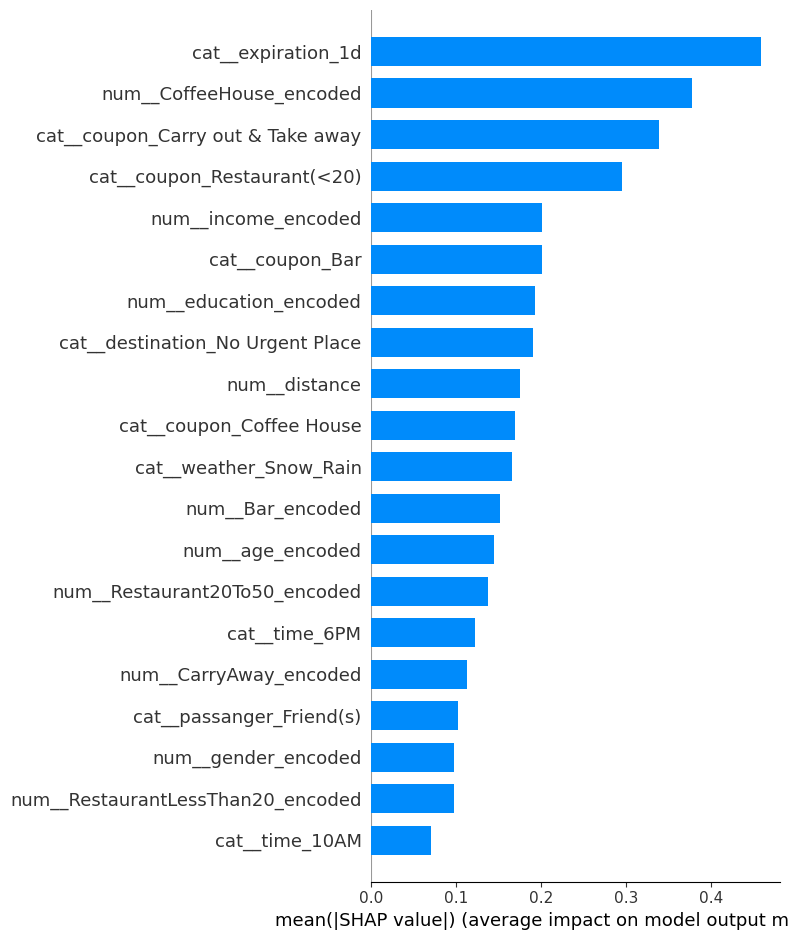

In [7]:
pipeline.fit(X_train,Y_train)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(preprocessor.transform(X_train))
shap_summary_plot = shap.summary_plot(shap_values, preprocessor.transform(X_train), feature_names=feature_names, plot_type='bar')
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
top_20_feature_indices = np.argsort(mean_abs_shap_values)[-20:][::-1]
top_20_features = [feature_names[i] for i in top_20_feature_indices]

In [8]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:, self.feature_indices]



In [9]:
# Create the pipeline with preprocessor, feature extractor, and model
shap_feature_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_extractor', FeatureExtractor(top_20_feature_indices)),
    ('model', None)
])

In [10]:
shap_feature_pipeline.set_params(model = XGBClassifier())
shap_feature_pipeline.fit(X_train,Y_train)

train_accuracy = shap_feature_pipeline.score(X_train, Y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Obtain the validation accuracy
val_accuracy = shap_feature_pipeline.score(X_val, Y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Training Accuracy: 0.9069
Validation Accuracy: 0.7621


In [11]:

param_dist = {
 'model__n_estimators': randint(100, 300),
 'model__learning_rate': uniform(0.001, 0.3),
 'model__max_depth': randint(2, 7),
 'model__min_child_weight': randint(1, 10),
 'model__subsample': uniform(0.8, 1.0 - 0.8),
 'model__colsample_bytree': uniform(0.8, 1.0 - 0.8 ),
}


# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(shap_feature_pipeline, param_distributions=param_dist, n_iter=330, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42, return_train_score=True)



random_search.fit(X_train, Y_train)


# Get the best model from the random search
best_xgb_model_random = random_search.best_estimator_

# Fit the best model to the full training set
best_xgb_model_random.fit(X_train, Y_train)

# Calculate the train score
train_score = best_xgb_model_random.score(X_train, Y_train)

# Retrieve the mean train score from cross-validation
mean_train_score_cv = np.mean(random_search.cv_results_['mean_train_score'])

# Print the scores
print("Train Score:", train_score)
print("Mean Train Score (CV):", mean_train_score_cv)
print("Best Mean Validation Score:", random_search.best_score_)
print("Best Hyperparameters:", random_search.best_params_)

# Compare the scores to assess overfitting
# if train_score - random_search.best_score_ > 0.1:
#     print("Warning: Potential overfitting detected. Train score is significantly higher than validation score.")



Fitting 10 folds for each of 330 candidates, totalling 3300 fits
Train Score: 0.909541511771995
Mean Train Score (CV): 0.7918915716437401
Best Mean Validation Score: 0.7494423791821563
Best Hyperparameters: {'model__colsample_bytree': 0.9953229911665306, 'model__learning_rate': 0.12431110399546938, 'model__max_depth': 6, 'model__min_child_weight': 1, 'model__n_estimators': 228, 'model__subsample': 0.8479123781333945}


In [12]:
xgb_model = XGBClassifier(
    colsample_bytree= 0.947571153381305,
    learning_rate= 0.10503362197574638, 
    max_depth=7,
    min_child_weight=1,
    n_estimators=251,
    subsample= 0.8465918949507268,
    reg_alpha=0.2,  # L1 regularization
    reg_lambda=10,   # L2 regularization
    early_stopping_rounds=100,  # Set early stopping directly in the model
    eval_metric='error'  # Set eval metric directly in the model
)



X = processed_data_predictors
Y = processed_data_target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify = Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)


eval_set = [(shap_feature_pipeline.set_params(model = None).transform(X_train),Y_train),
           (shap_feature_pipeline.set_params(model=None).transform(X_val), Y_val)]
shap_feature_pipeline.set_params(model = xgb_model)

shap_feature_pipeline.fit(X_train, Y_train,
    model__eval_set=eval_set
 )

train_accuracy = shap_feature_pipeline.score(X_train, Y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Obtain the validation accuracy
val_accuracy = shap_feature_pipeline.score(X_val, Y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

[0]	validation_0-error:0.43234	validation_1-error:0.43261
[1]	validation_0-error:0.40211	validation_1-error:0.39891
[2]	validation_0-error:0.35849	validation_1-error:0.36026
[3]	validation_0-error:0.31586	validation_1-error:0.32607
[4]	validation_0-error:0.29442	validation_1-error:0.30030
[5]	validation_0-error:0.28513	validation_1-error:0.29237
[6]	validation_0-error:0.28067	validation_1-error:0.29138
[7]	validation_0-error:0.27633	validation_1-error:0.27948
[8]	validation_0-error:0.26877	validation_1-error:0.27552
[9]	validation_0-error:0.26691	validation_1-error:0.27453
[10]	validation_0-error:0.26568	validation_1-error:0.27602
[11]	validation_0-error:0.26295	validation_1-error:0.27651
[12]	validation_0-error:0.25886	validation_1-error:0.27205
[13]	validation_0-error:0.25725	validation_1-error:0.26957
[14]	validation_0-error:0.25638	validation_1-error:0.27354
[15]	validation_0-error:0.25366	validation_1-error:0.27354
[16]	validation_0-error:0.25204	validation_1-error:0.27205
[17]	va

In [13]:
best_iteration = shap_feature_pipeline.named_steps['model'].best_iteration
best_iteration

180

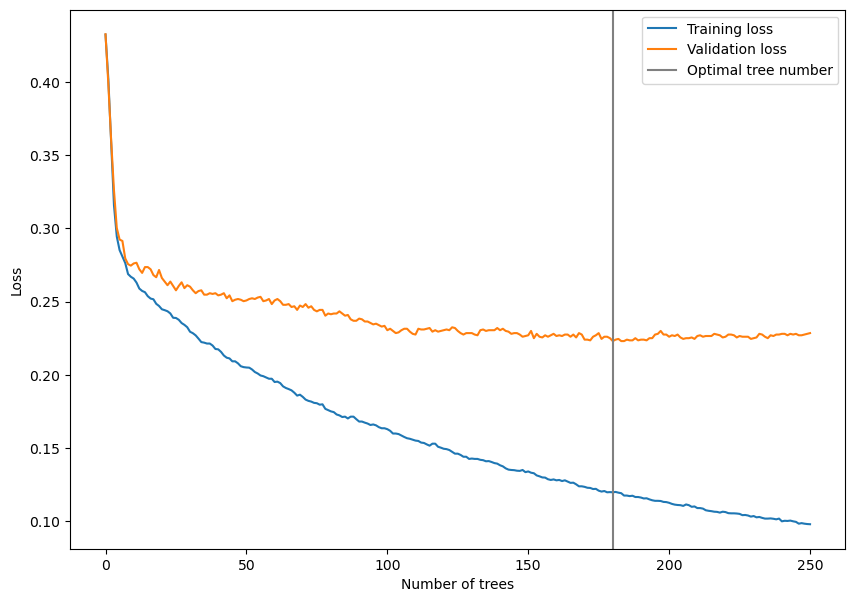

In [14]:
results = xgb_model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["error"], label="Training loss")
plt.plot(results["validation_1"]["error"], label="Validation loss")
plt.axvline(best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [15]:
final_xgb_model = XGBClassifier(
    colsample_bytree= 0.947571153381305,
    learning_rate= 0.10503362197574638, 
    max_depth=7,
    min_child_weight=1,
    n_estimators=best_iteration,
    subsample= 0.8465918949507268,
    reg_alpha=0.2,  # L1 regularization
    reg_lambda=10   # L2 regularization
    
)

final_pipeline = shap_feature_pipeline.set_params(model = final_xgb_model)


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify = Y)

In [17]:
final_pipeline.fit(X_train,Y_train)
final_pipeline.score(X_train,Y_train)

0.869746233148295

In [18]:
final_pipeline.score(X_test,Y_test)

0.760904044409199

In [19]:
Y_pred = final_pipeline.predict(X_test)

In [20]:
accuracy_score(Y_pred,Y_test)

0.760904044409199

In [21]:
precision_score(Y_pred,Y_test)

0.8113207547169812

In [22]:
recall_score(Y_pred,Y_test)

0.7771084337349398

In [23]:
f1_score(Y_pred,Y_test)

0.7938461538461539

In [24]:
roc_auc_score(Y_pred,Y_test)

0.7572312596690263

In [25]:
# Predict probabilities on the test set
Y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]

In [26]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)


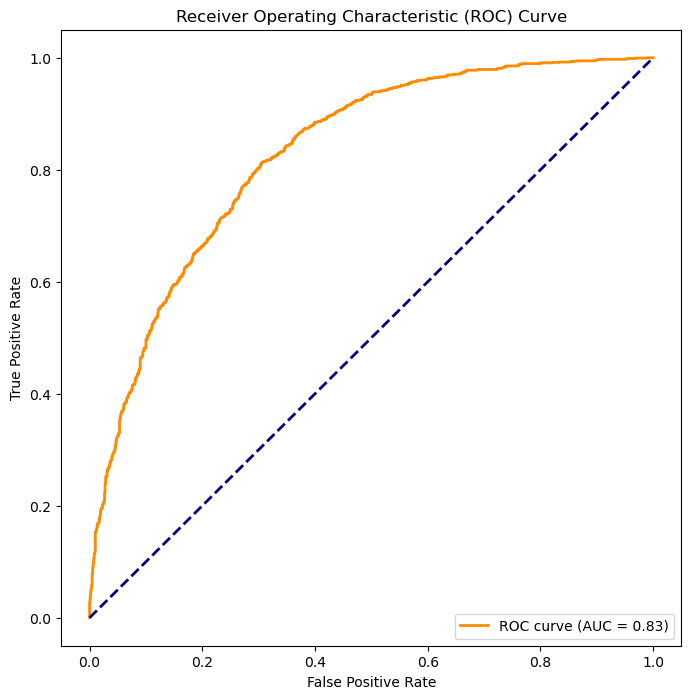

In [27]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()